# Introduction

This notebook is used to retrieve data from USGS using `dataRetrieval` R package. For tutorial, see [slides](https://owi.usgs.gov/R/dataRetrieval.html) and [documentation](https://pubs.usgs.gov/tm/04/a10/pdf/tm4A10_appendix_1.pdf). The source code is located at [Github](https://github.com/IRkernel/IRkernel).

Install the `dataRetrieval` R package

Download the dev version from github (**not stable**)

In [3]:
# library(devtools)
# install_github("USGS-R/dataRetrieval")

askpass  (NA       -> 1.1     ) [CRAN]
BH       (1.66.0-1 -> 1.69.0-1) [CRAN]
clipr    (0.4.1    -> 0.5.0   ) [CRAN]
curl     (3.2      -> 3.3     ) [CRAN]
httr     (1.3.1    -> 1.4.0   ) [CRAN]
jsonlite (1.5      -> 1.6     ) [CRAN]
openssl  (1.0.2    -> 1.2.2   ) [CRAN]
R6       (2.3.0    -> 2.4.0   ) [CRAN]
stringi  (1.2.4    -> 1.3.1   ) [CRAN]
stringr  (1.3.1    -> 1.4.0   ) [CRAN]
sys      (NA       -> 3.0     ) [CRAN]


Installing 11 packages: askpass, BH, clipr, curl, httr, jsonlite, openssl, R6, stringi, stringr, sys
Installing packages into ‘/Users/shua784/Library/R/3.5/library’
(as ‘lib’ is unspecified)



The downloaded binary packages are in
	/var/folders/b_/kpbcrn3s4_1770_6k278969jd__sdl/T//RtmpVlo12A/downloaded_packages
✔  checking for file ‘/private/var/folders/b_/kpbcrn3s4_1770_6k278969jd__sdl/T/RtmpVlo12A/remotes704f26d66d72/USGS-R-dataRetrieval-9460bc1/DESCRIPTION’ ...
─  preparing ‘dataRetrieval’:
✔  checking DESCRIPTION meta-information ...
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘dataRetrieval_2.7.4.tar.gz’
   


Installing package into ‘/Users/shua784/Library/R/3.5/library’
(as ‘lib’ is unspecified)


In [83]:
library(dplyr)
library(dataRetrieval)
library(leaflet)
library(htmlwidgets)
library(mapview)
library(rgdal)
# library(httr)
# set_config(verbose())
# set_config(progress())

Warning message:
“package ‘rgdal’ was built under R version 3.5.2”Loading required package: sp
rgdal: version: 1.3-9, (SVN revision 794)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Users/shua784/Library/R/3.5/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: /Users/shua784/Library/R/3.5/library/rgdal/proj
 Linking to sp version: 1.3-1 


In [253]:
# out_dir = "/global/project/projectdirs/m1800/pin/Reach_scale_model/data/well_data/GW_chemistry/"
out_dir = "~/Dropbox/PNNL/Projects/Delaware_river_basin/data/"
fig_dir = "~/Dropbox/PNNL/Projects/Delaware_river_basin/figures/"
gis_file = "~/Dropbox/PNNL/Projects/Delaware_river_basin/GIS/"

## parameter code

USGS use various codes for basic retrievals:

- site id
- parameter code ([full list](https://help.waterdata.usgs.gov/code/parameter_cd_query?fmt=rdb&inline=true&group_cd=%))

    - common codes
    
|code|name|$unit$|
|----|----|---|
|00010|Temperature, water|$deg C$|
|00060|discharge, |$ft^3/s$|
|00065|gage height, |$ft$|
|00095|Specific conductance, water, unfiltered|$uS/cm @25C$|
|00300| Dissolved oxygen|$mg/L$|
|00301|Diss oxygen| %saturtn
|00400| pH
|00618|nitrate, filtered (dissovled), water, |$mg/L$|
|00620|nitrate, unfiltered (total), water, |$mg/L$|
|63680| Turbidity | Form Neph
|72019|depth to water level| ft
|99133| NO3+NO2 water,insitu|$mg/L$

- statistic code ([full list](https://help.waterdata.usgs.gov/code/stat_cd_nm_query?stat_nm_cd=%25&fmt=html))

    - common codes
    
code|name
:---:|:---:
00001|maximum
00002|minimum
00003|mean

As an alternative, you can search for specific parameters or even download the complete parameter code names.

In [ ]:
#find all the parameter codes
parameterCdFile <- parameterCdFile
names(parameterCdFile)
write.csv(parameterCdFile,'parameterCdFile.csv')

In [ ]:
#find para codes with "nitrate"
NO3Cds <- parameterCdFile[grep("nitrate",
                                parameterCdFile$parameter_nm,
                                ignore.case=TRUE),]

## function names

Common query functions:

See examples of [readNWIS](https://owi.usgs.gov/R/training-curriculum/usgs-packages/dataRetrieval-readNWIS/) and [readWQP](https://owi.usgs.gov/R/training-curriculum/usgs-packages/dataRetrieval-readWQP/) on how to use each function.

Function|Description|arguments|example
:---:|:---:|:---:|:---:
whatNWISdata|discover what data is available at a site|siteNumbers,service, statCd|whatNWISdata(siteNumbers,service="dv", statCd="00003")
readNWISdata|user specified query|must include `service={'iv','dv','gwlevels','site','qw','measurement','stat'}`|box region selection, stateCd
readNWISdv| query *daily* data (e.g. daily freq)|siteNumbers, parameterCd, startDate, endDate, statCd|river gage, discharge, temperature
readNWISqw| quality data from water samples collected at the streamgage or other monitoring site (**different from `dv` autologger data**)|siteNumbers, parameterCd, startDate, endDate, expanded, reshape, tz|nitrate
readNWISuv|query *unit* data (e.g. 15 min freq., real-time)|siteNumbers, parameterCd, startDate, endDate, tz|river gage, discharge
readNWISgwl|query *groundwater level*|	siteNumbers, startDate, endDate, convertType, tz|
readNWISmeas| discrete measurements of discharge that are made for the purpose of developing or revising the rating curve|siteNumbers, startDate, endDate, tz, expanded, convertType|
readNWISpCode|parameter code info|readNWISpCode(parameterCd)
readNWISsite| site info| readNWISsite(siteNumbers)
readNWISuse|data from USGS nation water use program|	stateCd, countyCd, years, categories, convertType, transform|
renameNWISColumns|rename column names from NWIS retrievals|
readWQPqw|retrieve water quality data from USGS and EPA ([link](https://www.waterqualitydata.us/portal/))| siteNumbers, parameterCd, startDate, endDate| full site name is required, e.g., USGS-01234567, must know siteNumber and paraCd
readWQPdata|general function for query data|readWQPdata(statecode="WI",characteristicName="Phosphorus")| list of [characteristic names](https://www.waterqualitydata.us/public_srsnames/) and [acceptable arguments](https://www.waterqualitydata.us/webservices_documentation/#WQPWebServicesGuide-Submitting)
whatWQPsites|return sites info|whatWQPsites(statecode="WI",characteristicName="Phosphorus")| not as robust as `readNWISsite`



To access the help file for each function name, do the following `?FUNCTION`

In [88]:
?whatNWISdata

## output columns

Common output Dataframe column names:

name|description|example
---|---|---
site_no|site identification number|01463500
station_nm|site name|Delaware River at Trenton NJ
site_tp_cd|site type|ST, GW
dec_lat_va|decimal latitude
dec_long_va|decimal longitude
coord_ary_cd|latitude-longitude accuracy
alt_va|altutude of gage/land surface
alt_datum_cd|altitude datum
data_type_cd|dv, iv, gw, qw
parm_cd|parameter code|00010
stat_cd|statistic code|00001
begin_date|
end_date|
cout_nu|cout number

# query data based on known site id

**inputs**

In [204]:
# pCode <- c("00618","00620") #nitrate, water, mg/L
# pCode = "00010"
# pCode = c("00010", "00060", "00065")

# startDate <- "2019-01-01"
# endDate <- "2019-03-01"
siteNumber = c("01434025", "01434021", "0143400680")
siteNumber = "01434025"
# parameterCd = "00600"
pCode = c("00060", "00065")
startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()

statCd <- "00003" #00001	Maximum; 00002	Minimum ; 00003	Mean; 00008	Median

# siteNumber <- "12510500" # USGS 12510500 YAKIMA RIVER AT KIONA, WA
# siteNumber <- "12472800" # COLUMBIA RIVER BELOW PRIEST RAPIDS DAM, WA
# siteNumber <- "12514400" # Columbia river at Pasco bridge

**site information**

In [107]:
siteInfo <- readNWISsite(siteNumber)

In [108]:
names(siteInfo)

[1] "agency_cd"             "site_no"               "station_nm"           
 [4] "site_tp_cd"            "lat_va"                "long_va"              
 [7] "dec_lat_va"            "dec_long_va"           "coord_meth_cd"        
[10] "coord_acy_cd"          "coord_datum_cd"        "dec_coord_datum_cd"   
[13] "district_cd"           "state_cd"              "county_cd"            
[16] "country_cd"            "land_net_ds"           "map_nm"               
[19] "map_scale_fc"          "alt_va"                "alt_meth_cd"          
[22] "alt_acy_va"            "alt_datum_cd"          "huc_cd"               
[25] "basin_cd"              "topo_cd"               "instruments_cd"       
[28] "construction_dt"       "inventory_dt"          "drain_area_va"        
[31] "contrib_drain_area_va" "tz_cd"                 "local_time_fg"        
[34] "reliability_cd"        "gw_file_cd"            "nat_aqfr_cd"          
[37] "aqfr_cd"               "aqfr_type_cd"          "well_depth_va"        
[40] "hole_depth_va"         "depth_src_cd"          "project_no"

In [119]:
siteInfo$alt_va

[1] 390

**available data**

In [210]:
avail_data = whatNWISdata(siteNumber = siteNumber)

In [213]:
parameter_cd = avail_data$parm_cd

readNWISpCode(parameter_cd)

Warning message in readNWISpCode(parameter_cd):
“The following pCodes seem mistyped, and no information was returned: ”

parameter_cd parameter_group_nm
5     00008        Information       
10    00028        Information       
16    00098        Information       
67    50280        Information       
236   71999        Information       
372   82398        Information       
388   84164        Information       
922   91063        Information       
923   91064        Information       
924   91065        Information       
1353  99105        Information       
1359  99111        Information       
1516  99818        Information       
1548  99856        Information       
1562  99870        Information       
1616  00010        Physical          
1621  00020        Physical          
1623  00025        Physical          
1643  00060        Physical          
1644  00061        Physical          
1646  00064        Physical          
1647  00065        Physical          
1653  00076        Physical          
1662  00095        Physical          
1703  00400        Physical          
1706  00403        Physical          
1724  00900        Physical          
1726  00902        Physical          
1728  00904        Physical          
1747  30207        Physical          
⋮     ⋮            ⋮                 
12012 49288        Organics, other   
12118 50284        Organics, other   
13868 63162        Organics, other   
16383 03515        Radiochemical     
16384 03516        Radiochemical     
16408 04126        Radiochemical     
16409 04127        Radiochemical     
16464 09510        Radiochemical     
16465 09511        Radiochemical     
16554 22703        Radiochemical     
16975 75986        Radiochemical     
16976 75987        Radiochemical     
16977 75988        Radiochemical     
16978 75989        Radiochemical     
16979 75990        Radiochemical     
16989 76001        Radiochemical     
16992 76004        Radiochemical     
16993 76005        Radiochemical     
17000 80030        Radiochemical     
17001 80040        Radiochemical     
17003 80050        Radiochemical     
17004 80060        Radiochemical     
17079 82085        Stable Isotopes   
17950 70331        Sediment          
17976 80154        Sediment          
17977 80155        Sediment          
1     NA           NA                
2     NA           NA                
3     NA           NA                
4     NA           NA                
      parameter_nm                                                                                                                            
5     Sample accounting number                                                                                                                
10    Agency analyzing sample, code                                                                                                           
16    Sampling depth, meters                                                                                                                  
67    Site visit purpose, code                                                                                                                
236   Sample purpose, code                                                                                                                    
372   Sampling method, code                                                                                                                   
388   Sampler type, code                                                                                                                      
922   Diazinon-d10, surrogate, water, filtered (0.7 micron glass fiber filter), percent recovery                                              
923   Terbuthylazine, surrogate, water, filtered (0.7 micron glass fiber filter), percent recovery                                            
924   alpha-HCH-d6, surrogate, water, filtered (0.7 micron glass fiber filter), percent recovery                                              
1353  Type of replicate, code                                                

## daily data (discharge, stage)

In [269]:
siteNumber = c("01434025", "01434021", "0143400680", "01435000")
siteNumber = "01435000"

# pCode = c("00060", "00065")
pCode = "00060"
startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()

statCd <- "00003" #00001	Maximum; 00002	Minimum ; 00003	Mean; 00008	Median

In [270]:
data <- readNWISdv(siteNumber = siteNumber, parameterCd = pCode, startDate,  endDate)

data = renameNWISColumns(data)

data = data[data$Flow >= 0, ]

In [271]:
head(data)

agency_cd site_no  Date       Flow Flow_cd
1 USGS      01435000 1980-01-01 130  A      
2 USGS      01435000 1980-01-02 131  A      
3 USGS      01435000 1980-01-03 115  A      
4 USGS      01435000 1980-01-04 100  A      
5 USGS      01435000 1980-01-05 100  A      
6 USGS      01435000 1980-01-06 100  A

**convert gage datum**

In [272]:
#get variable and site info
variableInfo <- attr(data, "variableInfo")
siteInfo <- attr(data, "siteInfo")

In [273]:
# convert gage height
datum = siteInfo$alt_va
GH_new <- as.data.frame(lapply(data$GH, FUN=function(x) datum+x)) 

**plot data**

quartz_off_screen 
                3

pdf 
  2

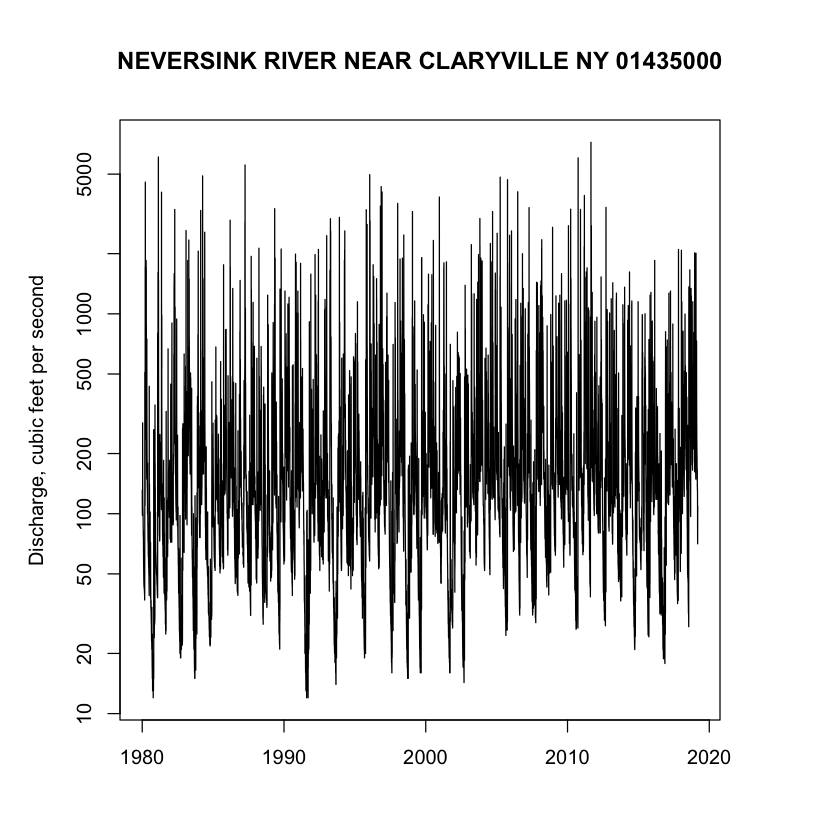

In [274]:
par(mar = c(5, 5, 5, 5))  #sets the margin (mar) size of the plot window

plot(data$Date, data$Flow, type="l", ylab = variableInfo$variableDescription[1], 
     xlab = "",  log="y")
par(new = TRUE)
# plot(data$Date, GH_new, col = "red", 
#      type = "l", xaxt = "n", yaxt = "n", xlab = "", ylab = "", 
#      axes = FALSE)
# axis(4, col = "red", col.axis = "red")
# mtext(variableInfo$variableDescription[2], side = 4, line = 3, col = "red")
titlename = paste(siteInfo$station_nm, siteInfo$site_no)
title(titlename)
# legend("topleft", variableInfo$unit, col = c("black", 
#                                                     "red"), lty = c(NA, 1), pch = c(1, NA))
dev.copy(jpeg, width=8,height=6,units='in',res=300,quality=100, 
         file = paste0(fig_dir,titlename,"_", variableInfo$variableDescription[1],".jpg"))
dev.off()

## quality data

In [344]:
siteNumber = c("01434025", "01434021", "0143400680", "01435000")
siteNumber = "01435000"

# pCode = c("00060", "00065")
# pCode = "00060"
pCode = "00681" #DOC
pCode = "00618" # nitrate
startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()

# statCd <- "00003" #00001	Maximum; 00002	Minimum ; 00003	Mean; 00008	Median

In [345]:
data <- readNWISqw(siteNumber = siteNumber, parameterCd = pCode, startDate,  endDate)

data = renameNWISColumns(data)

In [346]:
dim(data)

[1] 1184   35

In [347]:
#get variable and site info
variableInfo <- attr(data, "variableInfo")
siteInfo <- attr(data, "siteInfo")

**plot data**

quartz_off_screen 
                3

pdf 
  2

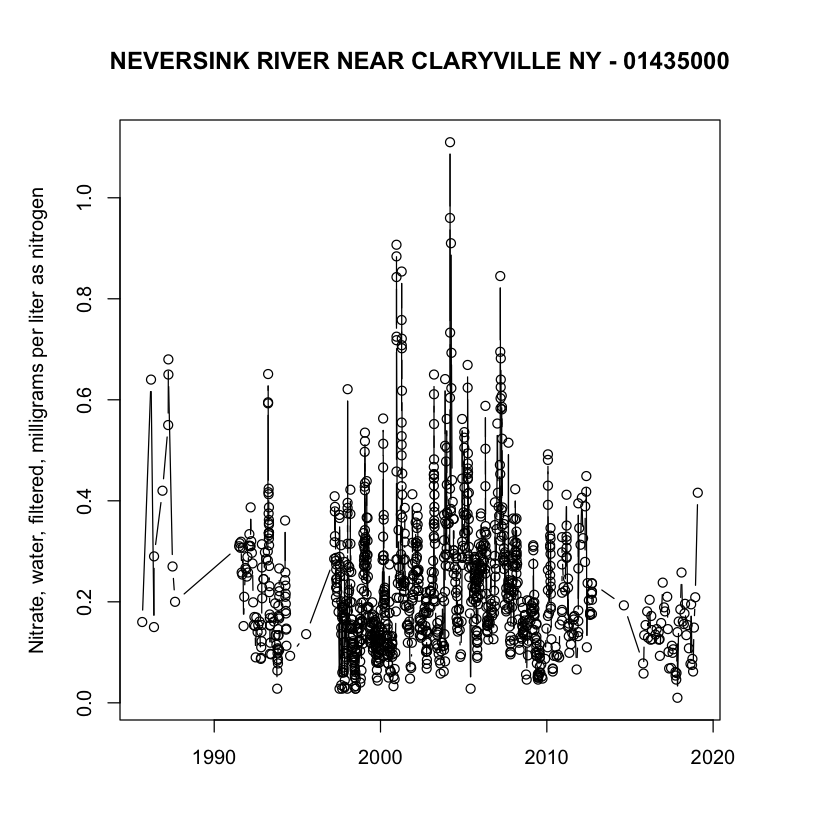

In [348]:
par(mar = c(5, 5, 5, 5))  #sets the margin (mar) size of the plot window

plot(data$sample_dt, data$result_va, type="b", ylab = variableInfo$parameter_nm, 
     xlab = "")
# par(new = TRUE)
# plot(data$Date, GH_new, col = "red", 
#      type = "l", xaxt = "n", yaxt = "n", xlab = "", ylab = "", 
#      axes = FALSE)
# axis(4, col = "red", col.axis = "red")
# mtext(variableInfo$variableDescription[2], side = 4, line = 3, col = "red")
titlename = paste(siteInfo$station_nm, "-",siteInfo$site_no)
title(titlename)
# legend("topleft", variableInfo$unit, col = c("black", 
#                                                     "red"), lty = c(NA, 1), pch = c(1, NA))
dev.copy(jpeg, width=8,height=6,units='in',res=300,quality=100, 
         file = paste0(fig_dir,titlename,"_", variableInfo$parameter_nm,".jpg"))
dev.off()

## groundwater level

In [457]:
# siteNumber = c("01434025", "01434021", "0143400680", "01435000")
# siteNumber = "97992339"
# siteNumber = "452840122302202"
# siteNumber = "465033122570202"
siteNumber = "415944074280801" #neversink

# pCode = c("00060", "00065")
# pCode = "00060"
# pCode = "00681" #DOC
# pCode = "00618" # nitrate
startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()

# statCd <- "00003" #00001	Maximum; 00002	Minimum ; 00003	Mean; 00008	Median

In [458]:
data <- readNWISgwl(siteNumbers = siteNumber,  startDate = startDate,  endDate = endDate)

# data = renameNWISColumns(data)

ERROR: Error in if (any(nchar(as.character(data$lev_dt)) <= 7) | any(grepl("[0-9]*-[0-9]*-00", : missing value where TRUE/FALSE needed


In [400]:
head(data)

agency_cd site_no         site_tp_cd lev_dt     lev_tm lev_tz_cd_reported
1 USGS      465033122570202 GW         1987-07-16 NA     UTC               
2 USGS      465033122570202 GW         1987-08-25 NA     UTC               
3 USGS      465033122570202 GW         1987-09-24 NA     UTC               
4 USGS      465033122570202 GW         1987-10-21 NA     UTC               
5 USGS      465033122570202 GW         1987-11-12 NA     UTC               
6 USGS      465033122570202 GW         1987-11-20 NA     UTC               
  lev_va sl_lev_va sl_datum_cd lev_status_cd lev_agency_cd lev_dateTime
1 30.0   NA        NA          NA            USGS          <NA>        
2 34.2   NA        NA          NA            USGS          <NA>        
3 36.9   NA        NA          NA            USGS          <NA>        
4 38.7   NA        NA          NA            USGS          <NA>        
5 39.9   NA        NA          NA            USGS          <NA>        
6 39.5   NA        NA          NA            USGS          <NA>        
  lev_tz_cd
1 UTC      
2 UTC      
3 UTC      
4 UTC      
5 UTC      
6 UTC

# query data based on selected region

## use state name 

In [4]:
pCode = c("00060", "00065")
# pCode = c("00060")
# pCode <- c("00662","00665")

**Query based on state name**

In [5]:
data <- readNWISdata(stateCd="WA", parameterCd=pCode,
                     service="site", seriesCatalogOutput=TRUE)

In [10]:
head(data)

agency_cd site_no  station_nm                   site_tp_cd dec_lat_va
1 USGS      12009500 BEAR BRANCH NEAR NASELLE, WA ST         46.32982  
2 USGS      12009500 BEAR BRANCH NEAR NASELLE, WA ST         46.32982  
3 USGS      12009500 BEAR BRANCH NEAR NASELLE, WA ST         46.32982  
4 USGS      12009500 BEAR BRANCH NEAR NASELLE, WA ST         46.32982  
5 USGS      12009500 BEAR BRANCH NEAR NASELLE, WA ST         46.32982  
6 USGS      12009500 BEAR BRANCH NEAR NASELLE, WA ST         46.32982  
  dec_long_va coord_acy_cd dec_coord_datum_cd alt_va alt_acy_va ⋯ stat_cd
1 -123.9115   S            NAD83               15.00  10        ⋯ 00001  
2 -123.9115   S            NAD83               15.00  10        ⋯ 00002  
3 -123.9115   S            NAD83               15.00  10        ⋯ 00003  
4 -123.9115   S            NAD83               15.00  10        ⋯ NA     
5 -123.9115   S            NAD83               15.00  10        ⋯ NA     
6 -123.9115   S            NAD83               15.00  10        ⋯ NA     
  ts_id  loc_web_ds medium_grp_cd parm_grp_cd srs_id  access_cd begin_date
1 148361 NA         wat           NA          1645597 0         1963-07-17
2 148362 NA         wat           NA          1645597 0         1963-07-17
3 148363 NA         wat           NA          1645423 0         1963-01-01
4      0 NA         wat           NA                0 0         1964-01-25
5      0 NA         wat           ALL               0 0         1907-08-09
6      0 NA         wat           PHY         1645597 0         1907-08-09
  end_date   count_nu
1 1966-09-29 1171    
2 1966-09-29 1171    
3 1975-09-29 4655    
4 1979-02-06   16    
5 1977-09-27   25    
6 1977-09-27   25

**refine the selection**

In [6]:
sub_data = filter(data, dec_lat_va >= "46.2" & dec_lat_va <= "47.0") %>%
  filter(dec_long_va >= "-118.6" & dec_long_va <= "-120.0") %>%
  filter(parm_cd %in% pCode)
# write.csv(NO3_hanford, paste(fname, "NO3_hanford.csv"))
siteNo = unique(sub_data$site_no)

In [11]:
head(sub_data)

agency_cd site_no  station_nm                                       
1 USGS      12435810 SCBID EL85 XX WASTEWAY NEAR MESA, WA             
2 USGS      12435840 SCBID EL85 JJ LATERAL AT HEAD NEAR MESA, WA      
3 USGS      12435850 SCBID EL85 CANAL BL EL85 JJ LATERAL NEAR MESA, WA
4 USGS      12464606 SAND HOLLOW CREEK AT S RD SW NEAR VANTAGE, WA    
5 USGS      12464606 SAND HOLLOW CREEK AT S RD SW NEAR VANTAGE, WA    
6 USGS      12466100 WEST CANAL NEAR ROYAL CITY, WA                   
  site_tp_cd dec_lat_va dec_long_va coord_acy_cd dec_coord_datum_cd alt_va  
1 ST         46.59458   -118.9920   S            NAD83              00685.00
2 ST         46.63458   -118.9900   S            NAD83              NA      
3 ST-CA      46.63486   -118.9906   S            NAD83              NA      
4 ST         46.93041   -119.8998   S            NAD83               910    
5 ST         46.93041   -119.8998   S            NAD83               910    
6 ST-CA      46.93486   -119.5648   S            NAD83              NA      
  alt_acy_va ⋯ stat_cd ts_id  loc_web_ds medium_grp_cd parm_grp_cd srs_id 
1  10        ⋯ 00003   149677 NA         wat           NA          1645423
2 NA         ⋯ 00003   149678 NA         wat           NA          1645423
3 NA         ⋯ 00003   149679 NA         wat           NA          1645423
4  10        ⋯ 00003   149861 NA         wat           NA          1645423
5  10        ⋯ NA      170682 NA         wat           NA          1645423
6 NA         ⋯ 00003   149870 NA         wat           NA          1645423
  access_cd begin_date end_date   count_nu
1 0         1986-07-09 1987-07-23  380    
2 0         1986-04-01 1987-04-30  244    
3 0         1986-04-01 1987-04-30  244    
4 0         1993-09-30 1995-09-30  731    
5 0         1993-09-30 1995-09-30  730    
6 0         1977-03-01 1981-10-31 1163

**plot in leaflet**

In [15]:
m <- leaflet(data=sub_data) %>% 
  addProviderTiles("CartoDB.Positron") %>%
  addCircleMarkers(~dec_long_va,~dec_lat_va,
                   color = "red", radius=3, stroke=FALSE,
                   fillOpacity = 0.5, opacity = 0.8,
                   popup=~station_nm)

In [16]:
m

HTML widgets cannot be represented in plain text (need html)

In [ ]:
saveWidget(m, file=paste(out_dir, "m.html", sep = ""))

## use box region

In [122]:
pCode = c("00010","00060", "00065","00095","00300","00301","00400","63680","72019","99133") # river gage parameters.

In [123]:
# latitude and longitude box region (lowerleft_lat, lowerleft_lon, upperright_lat, upperright_long)
# box.region = c(-120.0,46.2,-118.6,47.0) #hanford
box.region = c(-76.6,38.3,-74.0,42.6) #delaware river basin

### retrive sites available within the box region

In [39]:
## use long_lat box to query data from sites
sites <- readNWISdata(bBox = box.region, parameterCd = pCode, service="site", asDateTime = TRUE,
                     seriesCatalogOutput=TRUE)

In [61]:
sub_sites = filter(sites, parm_cd %in% pCode)

In [62]:
sub_sites = transform(sub_sites, begin_date = as.POSIXct(begin_date), end_date = as.POSIXct(end_date))

In [65]:
write.csv(sub_sites, paste(out_dir, "DRB_USGS_sites.csv", sep = ""))

**select sites up to date**

In [66]:
sub_sites_updated = filter(sub_sites, parm_cd %in% pCode & end_date > as.Date('2019-01-01'))

write.csv(sub_sites_updated, paste(out_dir, "DRB_USGS_sites_updated.csv", sep = ""))

In [77]:
unique_sites_parm <- sub_sites_updated[!duplicated(sub_sites_updated[c('site_no', 'parm_cd')]),] 

In [79]:
table(unique_sites_parm['parm_cd'])


00010 00060 00065 00095 00300 00301 00400 63680 72019 99133 
  239   375   445   160   147   135   150    64   198     5 

**plot in leaflet**

In [67]:
unique_sites <- sub_sites_updated[!duplicated(sub_sites_updated[c('site_no')]),] 

In [68]:
m <- leaflet(data=unique_sites) %>% 
  addProviderTiles("CartoDB.Positron") %>%
  addCircleMarkers(~dec_long_va,~dec_lat_va,
                   color = "green", radius=3, stroke=FALSE,
                   fillOpacity = 0.5, opacity = 0.8,
                   popup=~site_no)

In [69]:
m

HTML widgets cannot be represented in plain text (need html)

In [70]:
saveWidget(m, file=paste(out_dir, "USGS_sites_updated.html", sep = ""))

### retrive data within box region

In [134]:
pCode = '99133'
statCode = '00001'
start.Date <- "2019-02-01"
end.Date <- "2019-03-01"

In [135]:
## use long_lat box to query data from sites
data <- readNWISdata(bBox = box.region, parameterCd = pCode, statCd = statCode, service="qw", 
                     startDate = start.Date, endDate = end.Date , asDateTime = TRUE)

Downloading: 32 kB      

limit_output extension: Maximum message size of 10000 exceeded with 10018 characters

In [136]:
data = renameNWISColumns(data)

In [137]:
head(data)

agency_cd site_no  sample_dt  sample_tm sample_end_dt sample_end_tm
1 USGS      01367625 2019-02-05 09:40     NA            NA           
2 USGS      01367770 2019-02-06 07:40     NA            NA           
3 USGS      01367800 2019-02-05 11:50     NA            NA           
4 USGS      01368820 2019-02-05 14:30     NA            NA           
5 USGS      01378560 2019-02-05 14:00     NA            NA           
6 USGS      01378780 2019-02-07 11:30     NA            NA           
  sample_start_time_datum_cd_reported tm_datum_rlbty_cd coll_ent_cd medium_cd ⋯
1 EST                                 K                 USGS-WRD    WS        ⋯
2 EST                                 K                 USGS-WRD    WS        ⋯
3 EST                                 K                 USGS-WRD    WS        ⋯
4 EST                                 K                 USGS-WRD    WS        ⋯
5 EST                                 K                 USGS-WRD    WS        ⋯
6 EST                                 K                 USGS-WRD    WS        ⋯
  p99106 p99111 p99156 p99158 p99159 p99200 p99206 p99207 startDateTime      
1 NA     NA      40280 NA      40275 NA      10057 NA     2019-02-05 14:40:00
2 NA     NA      40280 NA      40275 NA      10057 NA     2019-02-06 12:40:00
3 NA     NA      40280 NA      40275 NA      10057 NA     2019-02-05 16:50:00
4 NA     NA      40280 NA      40275 NA      10057 NA     2019-02-05 19:30:00
5 NA     NA      40280 NA      40275 NA      10057 NA     2019-02-05 19:00:00
6 NA      10     40280 NA      40275 NA      10057 NA     2019-02-07 16:30:00
  sample_start_time_datum_cd
1 UTC                       
2 UTC                       
3 UTC                       
4 UTC                       
5 UTC                       
6 UTC

In [139]:
names(data)

[1] "agency_cd"                           "site_no"                            
 [3] "sample_dt"                           "sample_tm"                          
 [5] "sample_end_dt"                       "sample_end_tm"                      
 [7] "sample_start_time_datum_cd_reported" "tm_datum_rlbty_cd"                  
 [9] "coll_ent_cd"                         "medium_cd"                          
[11] "tu_id"                               "body_part_id"                       
[13] "p00004"                              "p00010"                             
[15] "p00020"                              "p00025"                             
[17] "p00032"                              "p00041"                             
[19] "p00061"                              "p00063"                             
[21] "p00065"                              "p00095"                             
[23] "p00191"                              "p00300"                             
[25] "p00301"                              "p00400"                             
[27] "p00403"                              "p00405"                             
[29] "p00452"                              "p00453"                             
[31] "p00530"                              "p00600"                             
[33] "p00602"                              "p00605"                             
[35] "p00607"                              "p00608"                             
[37] "p00613"                              "p00618"                             
[39] "p00623"                              "p00625"                             
[41] "p00631"                              "p00660"                             
[43] "p00665"                              "p00666"                             
[45] "p00671"                              "p00681"                             
[47] "p00940"                              "p00955"                             
[49] "p01032"                              "p01300"                             
[51] "p01305"                              "p01320"                             
[53] "p01325"                              "p01330"                             
[55] "p01340"                              "p01345"                             
[57] "p01350"                              "p01355"                             
[59] "p30207"                              "p30209"                             
[61] "p39086"                              "p50280"                             
[63] "p50468"                              "p50569"                             
[65] "p50624"                              "p61726"                             
[67] "p62854"                              "p63162"                             
[69] "p63676"                              "p63680"                             
[71] "p71846"                              "p71851"                             
[73] "p71856"                              "p71999"                             
[75] "p72053"                              "p72104"                             
[77] "p72105"                              "p72188"                             
[79] "p72219"                              "p72220"                             
[81] "p81904"                              "p82398"                             
[83] "p84164"                              "p84171"                             
[85] "p84182"                              "p99106"                             
[87] "p99111"                              "p99156"                             
[89] "p99158"                              "p99159"                             
[91] "p99200"                              "p99206"                             
[93] "p99207"                              "startDateTime"                      
[95] "sample_start_time_datum_cd"

In [138]:
dim(data)

[1] 134  95

In [19]:
## use long_lat box to query data from database
qwData_data <- readNWISdata(bBox=box.region, parameterCd = pCode, qw_attributes="expanded", service="qw")
# qwData_data_NO3 = filter(qwData_data, parm_cd %in% pCode)

In [27]:
df = data.frame(qwData_data$agency_cd, qwData_data$site_no, qwData_data$startDateTime, 
                             qwData_data$sample_start_time_datum_cd, qwData_data$p00010)
names(df) = c("agency","site_no", "DateTime", "tz", "temperature_C" )

In [29]:
write.csv(df, paste(out_dir, "USGS_temp_data.csv", sep = ""))

# retrieve data from Water Quality Portal

## output columns

Some key data columns are listed:

Column|Description|Example
---|---|---
OrganizationIdentifier|Data source|USGS-NJ
OrganizationFormalName|Data source|USGS New Jersey Water Science Center
MonitoringLocationIdentifier|location of the site|"USGS-01378690"
ActivityMediaName|media type|eg. water
ActivityStartDate|start date|eg. 2015-01-06
ActivityStartTime.Time|time of the day|eg. 10:00:00
ActivityEndDate|end date|eg. 2015-01-06
ActivityEndTime.Time|time of the day|eg. 10:00:00
CharacteristicName|chemical species|Nitrate
ResultSampleFractionText|specie type|e.g. Dissovled, Total, Unfilter
ResultMeasureValue|concentration|
ResultMeasure.MeasureUnitCode|unit|eg. mg/L
ProviderName|agency provider|eg. STORET

Some key attribute columns are listed: 

use function `attr(df, 'siteInfo')`

Column|Description|Example
---|---|---
site_no|site number|USGS-01378690
dec_lat_va|latitude|
dec_lon_va|longitude
hucCd|huc unit code|02030103
HUCEightDigitCode|"02030103"
LatitudeMeasure|latitude|
LongitudeMeasure|longitude|





## query based on region

**available sites**

In [459]:
media = "Water"
name = "Organic carbon" #"Organic carbon", "Nitrate", "Phosphorus", "Nitrogen"
sampleFraction = "Dissolved"
unit = "mg/L"

# parameterCd = "USGS-00600"
startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()
# startDate = Sys.Date() - 365*10 # past 10 years
box.region = c(-76.6,38.3,-74.0,42.6) #delaware river basin
HUCcode = c("02040201","02040202", "02040203", "02040204","02040205", 
            "02040206", "02040207", "02040101","02040102", "02040103", 
            "02040104","02040105", "02040106") # DRB
countrycode = "US"

query data, possible arguments: `characteristicName`, `characteristicType`, `parameterCd`,`bBox`, `siteid`,`statecode`,`countycode`,`providers`,`querySummary`(return # of unique sites). See [full list](https://www.waterqualitydata.us/webservices_documentation/#WQPWebServicesGuide-Submitting)

search for country

In [460]:
qwData <- readWQPdata(countrycode = countrycode, characteristicName=name, sampleMedia = media, startDate = startDate, 
                      endDate = endDate)

write.csv(qwData, file = paste0(out_dir, sampleFraction, " ", name,"_data_US.csv"))

search for HUC code

In [350]:
qwData <- readWQPdata(huc=HUCcode, characteristicName=name, sampleMedia = media, startDate = startDate, 
                      endDate = endDate)

write.csv(qwData, file = paste0(out_dir, sampleFraction, " ", name,"_data_80_19.csv"))

**convert `ug/l` to `mg/l`**

In [461]:
table(qwData$ResultMeasure.MeasureUnitCode)


         %       g/kg      mg/kg       mg/l mg/l             None        ppm 
      2155       1116         98    1901822     249320        510       2718 
ppm              ug/l ug/l             umol umol           umol/L 
      2788       2070         52       5525      12707       1880 

In [463]:
qwData = qwData %>% mutate(ResultMeasureValue = 
                           ifelse(grepl("ug/l", qwData$ResultMeasure.MeasureUnitCode, ignore.case = T), 
                                                       ResultMeasureValue/1000, ResultMeasureValue))

**get attributes of sites**

In [464]:
varInfo = attr(qwData, "variableInfo")
siteInfo <- attr(qwData, "siteInfo")

# dim(siteInfo)

In [451]:
# qwSummary = read.csv(paste0(out_dir, sampleFraction, " ",name,"_site_summary_80_19.csv"), stringsAsFactors=FALSE)

In [468]:
qwSummary <- qwData %>%
  filter(!is.na(ResultMeasureValue) & !is.na(ActivityStartDateTime)) %>%
  filter(ResultSampleFractionText %in% sampleFraction) %>%
  group_by(MonitoringLocationIdentifier) %>%
  summarise(count=n(),
            start=min(ActivityStartDateTime, na.rm = TRUE),
            end=max(ActivityStartDateTime, na.rm = TRUE),
            max = max(ResultMeasureValue, na.rm = TRUE),
           mean = mean(ResultMeasureValue, na.rm = TRUE),
           min = min(ResultMeasureValue, na.rm = TRUE)) %>%
  filter(count >= 1) %>%
  arrange(-count) %>%
  left_join(siteInfo, by = "MonitoringLocationIdentifier")

write.csv(qwSummary, file = paste0(out_dir, sampleFraction, " ",name,"_site_summary_US.csv"))

ERROR: Error in UseMethod("tbl_vars"): no applicable method for 'tbl_vars' applied to an object of class "NULL"


**import shapefile**

In [147]:
DRB_bound <- readOGR(paste0(gis_file, "DRB_bound/DRB_bound.shp") )
delaware_river <- readOGR(paste0(gis_file, "delawareriver/delawareriver.shp") )
delaware_river_trib <- readOGR(paste0(gis_file, "drb_riv_arc/drb_riv_arc.shp") )
neversink <- readOGR(paste0(gis_file, "Neversink/Neversink.shp") )
frenchCreek <- readOGR(paste0(gis_file, "french_creek_watershed/french_creek_watershed.shp") )
delawareGap <- readOGR(paste0(gis_file, "delaware_gap/delawareGap.shp") )

# transform cooridnated system
DRB_bound <- spTransform(DRB_bound, CRS("+proj=longlat +datum=WGS84 +no_defs"))
delaware_river <- spTransform(delaware_river, CRS("+proj=longlat +datum=WGS84 +no_defs"))
delaware_river_trib <- spTransform(delaware_river_trib, CRS("+proj=longlat +datum=WGS84 +no_defs"))
neversink <- spTransform(neversink, CRS("+proj=longlat +datum=WGS84 +no_defs"))
frenchCreek <- spTransform(frenchCreek, CRS("+proj=longlat +datum=WGS84 +no_defs"))
delawareGap <- spTransform(delawareGap, CRS("+proj=longlat +datum=WGS84 +no_defs"))

OGR data source with driver: ESRI Shapefile 
Source: "/Users/shua784/Dropbox/PNNL/Projects/Delaware_river_basin/GIS/DRB_bound/DRB_bound.shp", layer: "DRB_bound"
with 102 features
It has 5 fields
Integer64 fields read as strings:  UserId FNODE_ TNODE_ LPOLY_ RPOLY_ 
OGR data source with driver: ESRI Shapefile 
Source: "/Users/shua784/Dropbox/PNNL/Projects/Delaware_river_basin/GIS/delawareriver/delawareriver.shp", layer: "delawareriver"
with 154 features
It has 5 fields
OGR data source with driver: ESRI Shapefile 
Source: "/Users/shua784/Dropbox/PNNL/Projects/Delaware_river_basin/GIS/drb_riv_arc/drb_riv_arc.shp", layer: "drb_riv_arc"
with 282 features
It has 7 fields
OGR data source with driver: ESRI Shapefile 
Source: "/Users/shua784/Dropbox/PNNL/Projects/Delaware_river_basin/GIS/Neversink/Neversink.shp", layer: "Neversink"
with 1 features
It has 1 fields
OGR data source with driver: ESRI Shapefile 
Source: "/Users/shua784/Dropbox/PNNL/Projects/Delaware_river_basin/GIS/french_creek_wate

**plot on the map**

classify whether type is groundwater or surface water

In [452]:
qwSummary = mutate(qwSummary, marker = ifelse(grepl("Well", qwSummary$MonitoringLocationTypeName, ignore.case = T),"gw", "sw"))

add cumstom legend

In [453]:
# colors <- c("red", "white", "blue", "white", "blue", "red")
#         labels <- c("filled_square", "empty_square", "big_square", "empty_circle", "filled_circle", "big_circle")
#         sizes <- c(10, 20, 30, 10, 20, 30)
#         shapes <- c("square", "square", "square", "circle", "circle", "circle")
#         borders <- c("red", "blue", "black", "blue", "blue", "black")

addLegendCustom <- function(map, colors, labels, sizes, shapes, borders, opacity = 0.8){

            make_shapes <- function(colors, sizes, borders, shapes) {
                shapes <- gsub("circle", "50%", shapes)
                shapes <- gsub("square", "0%", shapes)
                paste0(colors, "; width:", sizes, "px; height:", sizes, "px; border:3px solid ", borders, "; border-radius:", shapes)
            }
            make_labels <- function(sizes, labels) {
                paste0("<div style='display: inline-block;height: ", 
                       sizes, "px;margin-top: 4px;line-height: ", 
                       sizes, "px;'>", labels, "</div>")
            }

            legend_colors <- make_shapes(colors, sizes, borders, shapes)
            legend_labels <- make_labels(sizes, labels)

            return(addLegend(map, colors = legend_colors, labels = legend_labels, opacity = opacity, title = "Site Type"))
        }

In [454]:
colors <- c("white", "darkblue")
        labels <- c("well", "stream/river")
        sizes <- c(10, 10)
        shapes <- c("circle", "circle")
        borders <- c("darkblue","darkblue")

col_types <- c("darkblue","dodgerblue","green4","gold1","orange","brown","red")
leg_vals <- unique(as.numeric(quantile(qwSummary$max, 
                probs=c(0,0.01,0.1,0.25,0.5,0.75,0.9,.99,1), na.rm=TRUE)))
pal = colorBin(col_types, qwSummary$max, bins = leg_vals)
rad <- 3*seq(1,4,length.out = 16)
qwSummary$sizes <- rad[as.numeric(cut(qwSummary$count, breaks=16))]

# iconlist = iconList(Msq = , Mcir = )
          
m = leaflet(data=qwSummary) %>% 
  addProviderTiles("CartoDB.Positron") %>%
  addPolygons(data=delawareGap, weight=2, col= 'green') %>%
  addPolygons(data=neversink, weight=2, col= 'green') %>%
  addPolygons(data=frenchCreek, weight=2, col= 'green') %>%
  addPolygons(data=delaware_river, weight=2, col= 'blue') %>%
  addPolylines(data=delaware_river_trib, weight=1, col= 'gray') %>%
  addPolylines(data=DRB_bound, weight=2, col= 'black') %>%
  addCircleMarkers(~dec_lon_va,~dec_lat_va,
                   fillColor = ~pal(max),radius = ~sizes,fillOpacity = ~ifelse(marker == "gw", 0, 0.8), 
                   stroke=T, opacity = 1,color = ~pal(max), weight = 1,
                   popup= paste("station:", qwSummary$station_nm, "<br>",
                                "id:", qwSummary$site_no, "<br>",
                                "type:", qwSummary$MonitoringLocationTypeName, "<br>",
                               "count:", qwSummary$count,  "<br>",
                               "max conc.:", qwSummary$max)) %>%
#   addMarkers(~dec_lon_va,~dec_lat_va,
#                    icon = ~iconlist[marker],
#                    fillColor = ~pal(max),
#                    radius = ~sizes,
#                    fillOpacity = 0.8, opacity = 0.8,stroke=FALSE,
#                    popup=~station_nm) %>%
  addLegend(position = 'bottomleft',
            pal=pal,
            values=~max,
            opacity = 0.8,
            labFormat = labelFormat(digits = 1), 
            title = paste0('Max Value (1980~present) <br>', '(', sampleFraction, ' ', name, '-', unit, ')' )) %>%
  addLegendCustom(colors, labels, sizes, shapes, borders)

In [455]:
m

HTML widgets cannot be represented in plain text (need html)

In [456]:
saveWidget(m, file=paste(out_dir,sampleFraction, " ", name,"_conc_map.html", sep = ""))
mapshot(m, file = paste(out_dir, sampleFraction, " ", name,"_conc_map.png", sep = ""))

## query based on single site

In [218]:
media = "Water"
name = "Organic carbon"
sampleFraction = "Dissolved"
unit = "mg/L"

siteID = c("USGS-01434025", "USGS-01434021", "USGS-0143400680")
# parameterCd = "00600"
# paraCd = c("00060", "00065")
paraCd = "00681" #DOC
startDate <- as.Date("1980-01-01")
# endDate = as.Date('2019-01-01')
endDate = Sys.Date()

In [219]:
qwData = readWQPqw(siteNumbers = siteID, parameterCd = paraCd, startDate = startDate, endDate = endDate)

ERROR: Error: Can't join on 'code' x 'ActivityEndTime/TimeZoneCode' because of incompatible types (character / logical)


In [190]:
qwData <- readWQPdata(siteid = siteID, characteristicName=name, sampleMedia = media, startDate = startDate, 
                      endDate = endDate)

ERROR: Error: Can't join on 'code' x 'ActivityEndTime/TimeZoneCode' because of incompatible types (character / logical)
